<a href="https://colab.research.google.com/github/ryan0124/ACEP_Capstone_Project/blob/main/Get_buildings_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Street Map Buildings Information

This notebook demonstrates downloading data from Open Street Map to fill gaps in the [Global Electricity Transmission And Distribution Lines](https://datacatalog.worldbank.org/dataset/derived-map-global-electricity-transmission-and-distribution-lines) (GETD) dataset.

To obtain GIS data from Open Street Map of any specified administrative area in the world, the [GeoFabrik](http://download.geofabrik.de/) download server is the easiest solution for querying data at the administrative level.

In this notebook, we address obtaining data for areas of Alaska

We will download the latest version of this data (currently 12/20/21) and extract the commercial, industrial and residential buildings information.


#Resources
* https://wiki.openstreetmap.org/wiki/Map_features#Power
* https://dlr-ve-esy.gitlab.io/esy-osmfilter/main.html
* https://stackoverflow.com/questions/66367195/get-all-ways-by-using-esy-osmfilter

### Mount Drive folder

Mount Drive folder for saving this data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get packages

Install packages needed for analysis and import into workspace.

In [ ]:
!pip install esy-osmfilter # gives tags and filters to open street map data
!pip install geopandas #to make working with geospatial data in python easier
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 16.7 MB 42.0 MB/s 
     |████████████████████████████████| 6.3 MB 39.4 MB/s 


In [ ]:
import configparser, contextlib
import os, sys
import geopandas as gpd
import pandas as pd
from esy.osmfilter import osm_colors as CC
from esy.osmfilter import run_filter 
from esy.osmfilter import Node, Way, Relation
from esy.osmfilter import export_geojson
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### To Downlaod the main pbf file (No need to run)

In [ ]:
## NO NEED TO RUN
!wget http://download.geofabrik.de/north-america/us/alaska-latest.osm.pbf -P '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'

--2022-03-09 04:44:44--  http://download.geofabrik.de/north-america/us/alaska-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 95.216.28.113, 116.202.112.212
Connecting to download.geofabrik.de (download.geofabrik.de)|95.216.28.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118348072 (113M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf.4’

alaska-latest.osm.p 100%[===================>] 112.87M  19.8MB/s    in 6.9s    

2022-03-09 04:44:51 (16.4 MB/s) - ‘/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf.4’ saved [118348072/118348072]



# Function to download different types of buildings



In [ ]:
# Getting residential buildings
def get_res_buildings(area_name): 
  
 # Set input/output locations
  PBF_inputfile = os.path.join(os.getcwd(), '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-latest.osm.pbf')
  JSON_outputfile = os.path.join(os.getcwd(),'/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-res_buildings.json')
  
  # Pre-filter for all residential buildings
  prefilter={Node: {}, Way: {"building":["apartments","bungalow","cabin","detached","dormitory","farm",
                                          "hotel","house","residential","church","garage","garages",],
                             "tourism":["alpine_hut","apartment","hostel","hotel","motel",
                                        ],
                             "addr":["postcode",],}, Relation: {}}
  whitefilter = []
  blackfilter = []
  
  # Create initial data
  [Data, _]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter,
                    blackfilter,
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)  
  # # Check that data exists
  print(len(Data['Way']))
  
  # # Get residential buildings elements
  whitefilter=[(("building","apartments"),), (("building","bungalow"),),(("building","cabin"),),
               (("building","detached"),), (("building","dormitory"),),(("building","farm"),),
               (("building","hotel"),), (("building","house"),),(("building","residential"),),
               (("building","church"),), (("building","garage"),),(("building","garages"),),
               (("tourism","alpine_hut"),), (("tourism","apartment"),),(("tourism","hostel"),),
               (("tourism","hotel"),), (("tourism","motel"),),(("addr","postcode"),),
               ]
  blackfilter=[((),),]
 
  # Apply filter
  [Data, Elements]=run_filter('powerlines',
                        PBF_inputfile, 
                        JSON_outputfile, 
                        prefilter,
                        whitefilter, 
                        blackfilter, 
                        NewPreFilterData=False, 
                        CreateElements=True, 
                        LoadElements=False,
                        verbose=True)
  
  print(len(Data['Way']))

  
  # Export data to geojson
  export_geojson(Elements['powerlines']['Way'],Data, filename='/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-res_buildings.geojson',jsontype='Line')
  
  # Read data into geopandas
  gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-res_buildings.geojson')
  
  # Write as shapefile
  gdf.to_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-res_buildings.shp')
  
  #Plot output
  gdf.plot()


In [ ]:
# Getting commercial buildings
def get_com_buildings(area_name): 
  
 # Set input/output locations
  PBF_inputfile = os.path.join(os.getcwd(), '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-latest.osm.pbf')
  JSON_outputfile = os.path.join(os.getcwd(),'/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-com_buildings.json')
  
  # Pre-filter for all commercial buildings
  prefilter={Node: {"amenity":["charging_staion","atm","strip_club",],}, Way: {"aeroway":["terminal",],"amenity":["bar","cafe","fast_food","food_court","pub","restaurant","college","kindergarten",
                                                                "library","school","university","bus_station","car_rental","car_wash",
                                                                "fuel","bank","clinic","dentist",
                                                                "doctor","hospital","nursing_home","pharmacy","socail_facility",
                                                                "veterinary","brothel","casino","cinema","community_centre",
                                                                "conference_centre","gambling","love_hotel","night_club",
                                                                "planetarium","studio","swingerclub",
                                                                "theatre","courthouse","embassy","fire_station",
                                                                "police","post_office","prison","townhall",
                                                                "creamatorium","internet_cafe","place_of_worship",],
                             "building":["commerical","office","retail","supermarket","warehouse","bakehouse","civic","college","fire_station",
                                         "government","hospital","kindergarten","public","school","train_staion","transportaion",
                                         "university","stadium","parking",],
                             "leisure":["adult_gaming_centre","amusement_arcade","beach_resort","fitness_centre",
                                        "sports_centre","stadium","summer_camp",],
                             "office":["accountant","association","charity","company","comsulting","courier",
                                       "dipomatic","educational_institution","employment_agency","engineer",
                                       "estate_agent","financial","forestry","foundation","government","insurance",
                                       "lawyer","logistics","moving_company","ngo","political_party",
                                       "property_management","religion","research","security","tax_advisor","telecommunication",
                                       "union","water_utility","yes"],
                             "shop":[True],
                             "tourism":["aquarium","gallery","museum","zoo","yes"],
                             "addr":["postcode",],}, Relation: {}}
  whitefilter = []
  blackfilter = []
  
  # Create initial data
  [Data, _]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter,
                    blackfilter,
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)  
  # # Check that data exists
  print(len(Data['Node']))
  
  # # Get commercial buildings elements
  whitefilter=[(("aeroway","terminal"),), (("amenity","bar"),), (("amenity","cafe"),), (("amenity","fast_food"),), (("amenity","food_court"),), (("amenity","pub"),), (("amenity","restaurant"),), 
               (("amenity","college"),), (("amenity","kindergarten"),), (("amenity","library"),), (("amenity","school"),), (("amenity","university"),), (("amenity","bus_station"),),
               (("amenity","car_rental"),), (("amenity","car_wash"),), (("amenity","fuel"),), (("amenity","bank"),), (("amenity","clinic"),), (("amenity","dentist"),), (("amenity","doctor"),),
               (("amenity","hospital"),), (("amenity","nursing_home"),), (("amenity","pharmacy"),), (("amenity","socail_facility"),), (("amenity","veterinary"),), (("amenity","brothel"),), 
               (("amenity","casino"),), (("amenity","cinema"),), (("amenity","community_centre"),), (("amenity","conference_centre"),), (("amenity","gambling"),), (("amenity","love_hotel"),),
               (("amenity","night_club"),), (("amenity","planetarium"),), (("amenity","studio"),), (("amenity","swingerclub"),), (("amenity","theatre"),), (("amenity","courthouse"),),
               (("amenity","embassy"),), (("amenity","fire_station"),), (("amenity","police"),), (("amenity","post_office"),), (("amenity","prison"),), (("amenity","townhall"),), (("amenity","creamatorium"),),
               (("amenity","internet_cafe"),), (("amenity","place_of_worship"),), (("building","commerical"),), (("building","office"),), (("building","retail"),), (("building","supermarket"),),
               (("building","warehouse"),), (("building","bakehouse"),), (("building","civic"),), (("building","college"),), (("building","fire_station"),), (("building","government"),),
               (("building","hospital"),), (("building","kindergarten"),), (("building","public"),), (("building","school"),), (("building","train_staion"),), (("building","transportaion"),),
               (("building","university"),), (("building","stadium"),), (("building","parking"),), (("leisure","adult_gaming_centre"),), (("leisure","amusement_arcade"),), (("leisure","beach_resort"),),
               (("leisure","amusement_arcade"),), (("leisure","amusement_arcade"),), (("leisure","amusement_arcade"),), (("leisure","amusement_arcade"),), (("leisure","amusement_arcade"),),
               (("leisure","fitness_centre"),), (("leisure","sports_centre"),), (("leisure","stadium"),), (("leisure","summer_camp"),), (("office","accountant"),), (("office","association"),),
               (("office","charity"),), (("office","company"),), (("office","comsulting"),), (("office","courier"),), (("office","dipomatic"),), (("office","educational_institution"),),
               (("office","employment_agency"),), (("office","engineer"),), (("office","estate_agent"),), (("office","financial"),), (("office","forestry"),), (("office","foundation"),),
               (("office","government"),), (("office","insurance"),), (("office","lawyer"),), (("office","logistics"),), (("office","moving_company"),), (("office","ngo"),),
               (("office","political_party"),), (("office","property_management"),), (("office","religion"),), (("office","research"),), (("office","security"),), (("office","tax_advisor"),),
               (("office","telecommunication"),), (("office","union"),), (("office","water_utility"),), (("office","yes"),), (("shop",True),), (("tourism","aquarium"),), (("tourism","gallery"),),
               (("tourism","museum"),), (("tourism","yes"),), (("addr","postcode"),),
               ]
  blackfilter=[((),),]
 
  # Apply filter
  [Data, Elements]=run_filter('powerlines',
                        PBF_inputfile, 
                        JSON_outputfile, 
                        prefilter,
                        whitefilter, 
                        blackfilter, 
                        NewPreFilterData=False, 
                        CreateElements=True, 
                        LoadElements=False,
                        verbose=True)
  
  print(len(Data['Node']))

  # Export data to geojson
  export_geojson(Elements['powerlines']['Way'],Data, filename='/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-com_buildings.geojson',jsontype='Line')
  
  # Read data into geopandas
  gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-com_buildings.geojson')
  
  # Write as shapefile
  gdf.to_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-com_buildings.shp')
  
  #Plot output
  gdf.plot()


In [ ]:
# Getting industrial buildings
def get_ind_buildings(area_name): 
  
 # Set input/output locations
  PBF_inputfile = os.path.join(os.getcwd(), '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-latest.osm.pbf')
  JSON_outputfile = os.path.join(os.getcwd(),'/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-ind_buildings.json')
  
# Pre-filter for all industrial buildings
  prefilter={Node: {}, Way: {"building":["industrial","digestor","service","transformer_tower","water_tower",
                                         "military",],
                             "historic":["creamery",],
                             "man_made":["lighthouse","monitoring_station","observatory",
                                        "pumping_staition","wastewater_plant","water_works",
                                        "works",],
                             "military":["base","barracks",],
                             "public_transport":["station",],
                             "railway":["station",],
                             "telecom":["data_center",],
                             "water":["wastewater",],
                             "waterway":["dock","boatyard",],
                             "addr":["postcode",],
                             }, Relation: {}}
  whitefilter = []
  blackfilter = []
  
  # Create initial data
  [Data, _]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter,
                    blackfilter,
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)  
  # # Check that data exists
  print(len(Data['Node']))
  
  # Get industrial buildings elements
  whitefilter=[(("building","industrial"),), (("building","digestor"),), (("building","service"),), (("building","transformer_tower"),), (("building","water_tower"),), (("building","military"),),
               (("historic","creamery"),), (("military","barracks"),), (("military","base"),), (("public_transport","station"),), (("railway","station"),), (("telecom","data_center"),), 
               (("water","wastewater"),), (("waterway","dock"),), (("waterway","boatyard"),), (("addr","postcode"),), (("man_made","lighthouse"),), (("man_made","monitoring_station"),),
               (("man_made","observatory"),), (("man_made","wastewater_plant"),), (("man_made","pumping_staition"),), (("man_made","water_works"),), (("man_made","works"),),
              ]
  blackfilter=[((),),]
 
  # Apply filter
  [Data, Elements]=run_filter('powerlines',
                        PBF_inputfile, 
                        JSON_outputfile, 
                        prefilter,
                        whitefilter, 
                        blackfilter, 
                        NewPreFilterData=False, 
                        CreateElements=True, 
                        LoadElements=False,
                        verbose=True)
  
  print(len(Data['Node']))
  #data = Data['Way']
  #df = pd.DataFrame(data)
  #return (df)

  #return (Data['Way'])

  # Export data to geojson
  export_geojson(Elements['powerlines']['Way'],Data, filename='/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-ind_buildings.geojson',jsontype='Line')
  
  # Read data into geopandas
  gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-ind_buildings.geojson')
  
  # Write as shapefile
  gdf.to_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-ind_buildings.shp')
  
  #Plot output
  gdf.plot()

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 118163          kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 16.88           s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmf

38960
38960


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


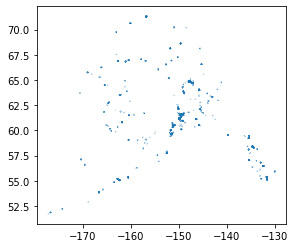

In [ ]:
# commercial buildings data
get_com_buildings('alaska')

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 118163          kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 16.88           s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmf

5563
5563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


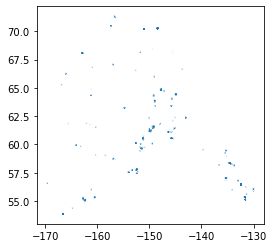

In [ ]:
# industrial buildings data
get_ind_buildings('alaska')

Streaming output truncated to the last 5000 lines.
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1

12295
12295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


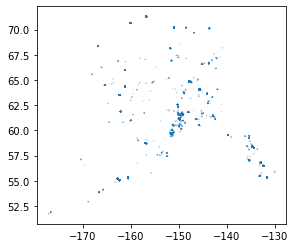

In [ ]:
# residential buildings data
get_res_buildings('alaska')

In [ ]:
import pandas as pd
#Chenk the size of the data
res_data=pd.read_json('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-res_buildings.json')
len(res_data)

102032

In [ ]:
#Chenk the size of the data
com_data=pd.read_json('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-com_buildings.json')
len(com_data)

42907

In [ ]:
#Chenk the size of the data
ind_data=pd.read_json('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-ind_buildings.json')
len(ind_data)

5653